In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.17.0


In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\ZeeD\\.keras\\datasets\\auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
# Aplicamos el one-hot encoding y modificamos directamente el dataset
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='Origin')

# Opcional: Renombrar las columnas si lo prefieres
dataset = dataset.rename(columns={'Origin_1': 'USA', 'Origin_2': 'Europe', 'Origin_3': 'Japan'})

# Revisamos el DataFrame actualizado
print(dataset.head())

    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year   USA  Europe  Japan  
0          70  True   False  False  
1          70  True   False  False  
2          70  True   False  False  
3          70  True   False  False  
4          70  True   False  False  


In [8]:
dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

In [9]:
from sklearn.model_selection import train_test_split

X = dataset.drop(columns=["MPG"])
y = dataset.pop("MPG")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=6)

In [10]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

pipeline = Pipeline([
    ('scaler', StandardScaler()),                     # Normalización
    ('poly', PolynomialFeatures(include_bias=False)), # Atributos polinómicos
    ('regression', Lasso())                            # Modelo de regresión con regularización Lasso
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],    # Grados de polinomios
    'regression__alpha': [0.01, 0.1, 1.0, 10.0],  # Valores de regularización
    'regression__fit_intercept': [True, False]  # Ajustar el intercepto
}

# Usar RandomizedSearchCV para ajustar los hiperparámetros
search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, 
                            scoring='neg_mean_squared_error', cv=5, random_state=42)

search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Best parameters found: {search.best_params_}")

# Predecir con el mejor modelo
y_test_pred = search.best_estimator_.predict(X_test)

# Evaluar el modelo
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"MSE (test) with Lasso: {mse_test}")
print(f"RMSE (test) with Lasso: {np.sqrt(mse_test)}")
std_dev = np.std(y_test)
print(f"Standard Deviation: {std_dev}")
r2_test = r2_score(y_test, y_test_pred)
print(f"R2 ->{r2_test}")

c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.764e+01, tolerance: 1.372e+00
  model = cd_fast.enet_coordinate_descent(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.060e+02, tolerance: 1.363e+00
  model = cd_fast.enet_coordinate_descent(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+02, tolerance: 1.393e+00
  model = cd_fast.enet_

Best parameters found: {'regression__fit_intercept': False, 'regression__alpha': 0.1, 'poly__degree': 3}
MSE (test) with Lasso: 5.8604848427844916
RMSE (test) with Lasso: 2.4208438286648093
Standard Deviation: 7.67723221134341
R2 ->0.9005684536803158


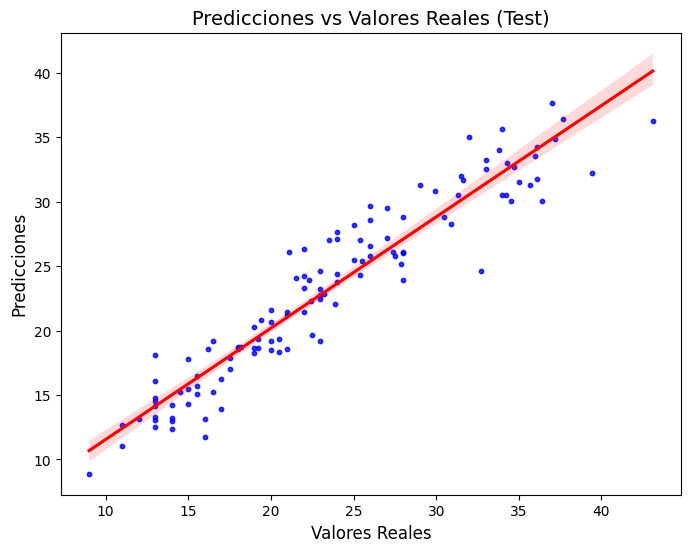

In [11]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_test_pred, scatter_kws={'color': 'blue', 's': 10}, line_kws={'color': 'red'})
plt.title("Predicciones vs Valores Reales (Test)", fontsize=14)
plt.xlabel("Valores Reales", fontsize=12)
plt.ylabel("Predicciones", fontsize=12)
plt.show()